# Factor Analysis vs PCA: Educational Assessment Case Study

## The Case

This analysis examines assessment data from 200 students across nine different measures:
- **Quantitative domain**: MathScore, AlgebraScore, GeometryScore
- **Verbal domain**: ReadingComp, Vocabulary, Writing
- **Interpersonal domain**: Collaboration, Leadership, Communication

**Central question**: Do these nine assessments measure three distinct underlying constructs (Quantitative, Verbal, Interpersonal), or do they reflect a different latent structure?

**Why this matters**: Understanding the true dimensionality helps determine whether these assessments effectively capture separate abilities or if they're redundant.

## Learning Objectives

By completing this analysis, you will:
- Apply Factor Analysis to discover latent psychological constructs
- Apply PCA to identify underlying dimensions in multivariate data
- Test statistical assumptions (KMO, Bartlett's test)
- Understand communalities and uniquenesses in measurement models
- Use factor rotation to achieve simple structure and interpretability
- Compare Factor Analysis with Principal Component Analysis
- Interpret factor loadings for construct validation

## Module 1: Import Libraries and Setup

**Task**: Set up your Python environment by importing the necessary libraries for Factor Analysis and PCA. You need pandas and numpy for data handling, matplotlib and seaborn for visualization, scikit-learn's PCA and StandardScaler, and the factor_analyzer package for Factor Analysis functions.

**Approach**: Before analyzing the data, you need statistical and visualization tools. Factor Analysis requires the factor_analyzer library (FactorAnalyzer for the main implementation, calculate_kmo and calculate_bartlett_sphericity for assumption testing). PCA comes from sklearn.decomposition. StandardScaler ensures all nine assessment variables contribute equally by transforming them to mean=0 and std=1, preventing variables with larger numerical ranges from dominating the analysis.

**Code**:

In [ ]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Simple logger
import logging

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

**Outcome**: All libraries imported successfully. Your environment is ready for statistical analysis. The logger will track analysis steps throughout the notebook, making it easier to follow the analytical process.

## Module 2: Data Loading and Exploration

**Task**: Load the educational assessment data from the CSV file and extract the nine assessment variables for analysis. Verify the data exists and check its dimensions.

**Approach**: The data file (educational.csv) contains 200 student records with 10 columns: Student ID plus 9 assessment scores. You'll use pandas to read the CSV, extract only the assessment columns (excluding Student ID), and log basic information about the dataset structure. This step verifies you have the correct data before proceeding with statistical analysis.

**Code**:

In [2]:
script_dir = Path.cwd()
data_path = script_dir / "educational.csv"

if not data_path.exists():
    logger.error(f"Data file not found: {data_path}")
    logger.info("Run 'fetch_educational.py' to generate the required data file")
    sys.exit(1)

df = pd.read_csv(data_path)
logger.info(
    f"Loaded dataset: {len(df)} students, {len(df.columns) - 1} assessment variables"
)

# Extract assessment variables (exclude Student ID)
X = df.iloc[:, 1:]
variable_names = list(X.columns)

logger.info(f"Assessment variables: {variable_names}")
logger.info(f"Data shape: {X.shape}")

INFO: Loaded dataset: 200 students, 9 assessment variables
INFO: Assessment variables: ['MathScore', 'AlgebraScore', 'GeometryScore', 'ReadingComp', 'Vocabulary', 'Writing', 'Collaboration', 'Leadership', 'Communication']
INFO: Data shape: (200, 9)


**Outcome**: The data loaded successfully with 200 students and 9 assessment variables (MathScore, AlgebraScore, GeometryScore, ReadingComp, Vocabulary, Writing, Collaboration, Leadership, Communication). The dataset structure matches expectations: three variables for each of the three theoretical domains (Quantitative, Verbal, Interpersonal).

## Module 3: Data Standardization

**Task**: Standardize all assessment variables to have mean 0 and standard deviation 1.

**Approach**: Factor Analysis and PCA are sensitive to variable scales. If variables have different ranges (e.g., some 0-100, others 0-5), larger-scale variables would dominate the analysis artificially. StandardScaler transforms each variable to z-scores: subtracting the mean and dividing by the standard deviation. This ensures all nine assessments contribute equally based on their actual correlations, not their measurement scales.

**Code**:

In [3]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

logger.info("Data standardized: mean ≈ 0, std ≈ 1 for all variables")

INFO: Data standardized: mean ≈ 0, std ≈ 1 for all variables


**Outcome**: All variables now have mean approximately 0 and standard deviation approximately 1. The data is ready for Factor Analysis and PCA, with each assessment contributing equally regardless of its original measurement scale.

## Module 4: Factor Analysis Assumptions Testing

**Task**: Test whether the data meets the statistical assumptions required for Factor Analysis using Bartlett's Test of Sphericity and the Kaiser-Meyer-Olkin (KMO) measure.

**Approach**: Factor Analysis assumes variables are correlated enough to share common variance. Two tests verify this: (1) Bartlett's Test checks if the correlation matrix is significantly different from an identity matrix (p < 0.05 means sufficient correlation). (2) KMO measures sampling adequacy (>0.6 acceptable, >0.8 good, >0.9 excellent). If assumptions fail, Factor Analysis results won't be meaningful.

**Code**:

In [4]:
# Test statistical assumptions
chi_square_value, p_value = calculate_bartlett_sphericity(X_standardized)
kmo_all, kmo_model = calculate_kmo(X_standardized)

logger.info("Factor Analysis Assumptions Testing:")
logger.info("\nBartlett's Test of Sphericity:")
logger.info(f"  Chi-square statistic: {chi_square_value:.3f}")
logger.info(f"  p-value: {p_value:.6f}")
if p_value < 0.05:
    logger.info("  ✓ Significant - variables are sufficiently correlated for FA")
else:
    logger.info("  ✗ Not significant - FA may not be appropriate")

logger.info("\nKaiser-Meyer-Olkin (KMO) Test:")
logger.info(f"  Overall Measure of Sampling Adequacy: {kmo_model:.3f}")
if kmo_model > 0.9:
    adequacy = "Excellent"
elif kmo_model > 0.8:
    adequacy = "Good"
elif kmo_model > 0.6:
    adequacy = "Acceptable"
else:
    adequacy = "Unacceptable"
logger.info(f"  Interpretation: {adequacy} sampling adequacy")

INFO: Factor Analysis Assumptions Testing:
INFO: 
Bartlett's Test of Sphericity:
INFO:   Chi-square statistic: 1393.938
INFO:   p-value: 0.000000
INFO:   ✓ Significant - variables are sufficiently correlated for FA
INFO: 
Kaiser-Meyer-Olkin (KMO) Test:
INFO:   Overall Measure of Sampling Adequacy: 0.799
INFO:   Interpretation: Acceptable sampling adequacy


**Outcome**: Bartlett's test is highly significant (p < 0.001), confirming variables are sufficiently correlated. KMO = 0.799 indicates acceptable sampling adequacy. Both tests pass, meaning the data is suitable for Factor Analysis. You can proceed with confidence that factor extraction will yield meaningful results.

### Individual Variable Adequacy

**Task**: Examine the KMO measure for each individual variable to identify any problematic assessments.

**Approach**: While the overall KMO is acceptable, individual variables might have low sampling adequacy (MSA < 0.6), indicating they don't correlate well with others. Such variables should be flagged or potentially removed.

**Code**:

In [5]:
logger.info("\nIndividual Variable Sampling Adequacy:")
for i, var_name in enumerate(variable_names):
    msa_value = kmo_all[i]
    logger.info(f"  {var_name}: {msa_value:.3f}")

# Flag any problematic variables
low_msa_vars = [
    var_name for i, var_name in enumerate(variable_names) if kmo_all[i] < 0.6
]
if low_msa_vars:
    logger.warning(f"Variables with low MSA (<0.6): {low_msa_vars}")
else:
    logger.info("All variables show adequate sampling adequacy (MSA ≥ 0.6)")

INFO: 
Individual Variable Sampling Adequacy:
INFO:   MathScore: 0.793
INFO:   AlgebraScore: 0.728
INFO:   GeometryScore: 0.850
INFO:   ReadingComp: 0.816
INFO:   Vocabulary: 0.818
INFO:   Writing: 0.815
INFO:   Collaboration: 0.784
INFO:   Leadership: 0.790
INFO:   Communication: 0.797
INFO: All variables show adequate sampling adequacy (MSA ≥ 0.6)


**Outcome**: All nine variables show adequate sampling adequacy (MSA >= 0.6), with values ranging from 0.728 to 0.850. No variables need to be removed. All assessments correlate sufficiently with others to contribute meaningfully to the factor solution.

## Module 5: Factor Extraction with Principal Axis Factoring

**Task**: Extract 3 factors using Principal Axis Factoring without rotation and examine the eigenvalues and communalities.

**Approach**: Principal Axis Factoring (PAF) separates common variance (shared among variables) from unique variance (specific to each variable plus error). You'll extract 3 factors based on theoretical expectation of three constructs. Eigenvalues show how much variance each factor captures. Communalities (h²) indicate how much of each variable's variance is explained by the common factors.

**Code**:

In [6]:
# Determine number of factors to extract
n_factors = 3  # Based on theoretical expectation of quantitative, verbal, and interpersonal factors

fa_unrotated = FactorAnalyzer(n_factors=n_factors, rotation=None, method="principal")
fa_unrotated.fit(X_standardized)

# Verify successful extraction
if fa_unrotated.loadings_ is None:
    logger.error("Factor extraction failed - no loadings produced")
    sys.exit(1)

logger.info(f"Factor Analysis Results ({n_factors} factors extracted):")
eigenvalues_fa = fa_unrotated.get_eigenvalues()[0]
logger.info(f"Eigenvalues: {np.round(eigenvalues_fa[:n_factors], 3)}")

k:\ma2003b\ma2003b.worktrees\dev\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
INFO: Factor Analysis Results (3 factors extracted):
INFO: Eigenvalues: [4.041 2.124 1.635]


**Outcome**: Successfully extracted 3 factors with eigenvalues [4.041, 2.124, 1.635], all exceeding 1.0 (Kaiser criterion). This confirms a three-factor structure. The factors will now be examined to understand what they represent.

### Communalities and Variance Decomposition

**Task**: Extract communalities and uniquenesses to understand how much variance in each variable is explained by the common factors.

**Approach**: Each variable's variance splits into communality (h² = variance explained by factors) and uniqueness (u² = unique + error variance). High communalities (>0.6) indicate variables are well-explained by the factor model.

**Code**:

In [7]:
communalities = fa_unrotated.get_communalities()
uniquenesses = 1 - communalities

logger.info("\nVariance Decomposition (Communalities and Uniquenesses):")
for i, var_name in enumerate(variable_names):
    h2 = communalities[i]
    u2 = uniquenesses[i]
    logger.info(f"  {var_name}: h² = {h2:.3f}, u² = {u2:.3f}")

# Analyze overall variance structure
factor_variance = np.sum(communalities)
total_variance = len(variable_names)  # For standardized data
variance_explained_fa = factor_variance / total_variance

logger.info("\nOverall Variance Analysis:")
logger.info(f"Total standardized variance: {total_variance:.1f}")
logger.info(f"Common variance (Σh²): {factor_variance:.3f}")
logger.info(f"Proportion of variance explained by factors: {variance_explained_fa:.1%}")
logger.info(f"Average communality: {np.mean(communalities):.3f}")

INFO: 
Variance Decomposition (Communalities and Uniquenesses):
INFO:   MathScore: h² = 0.879, u² = 0.121
INFO:   AlgebraScore: h² = 0.905, u² = 0.095
INFO:   GeometryScore: h² = 0.848, u² = 0.152
INFO:   ReadingComp: h² = 0.852, u² = 0.148
INFO:   Vocabulary: h² = 0.838, u² = 0.162
INFO:   Writing: h² = 0.852, u² = 0.148
INFO:   Collaboration: h² = 0.874, u² = 0.126
INFO:   Leadership: h² = 0.873, u² = 0.127
INFO:   Communication: h² = 0.880, u² = 0.120
INFO: 
Overall Variance Analysis:
INFO: Total standardized variance: 9.0
INFO: Common variance (Σh²): 7.801
INFO: Proportion of variance explained by factors: 86.7%
INFO: Average communality: 0.867


**Outcome**: All variables show high communalities (h² > 0.8), ranging from 0.838 to 0.905. The three factors explain 86.7% of the total variance, with an average communality of 0.867. This confirms the nine assessments are well-explained by three underlying constructs, with minimal unique variance.

## Module 6: Inspect and Interpret Unrotated Factors

**Task**: Examine the unrotated factor loadings to understand what each factor represents and identify problems with interpretability.

**Approach**: Factor loadings show correlations between variables and factors. Unrotated solutions maximize variance extraction but often lack interpretability. You'll display the loadings matrix and analyze patterns to identify issues like general factors, bipolar contrasts, and lack of simple structure.

**Code**:

In [8]:
# Extract the unrotated loadings from the fitted model
loadings_unrotated = fa_unrotated.loadings_

# Create a detailed DataFrame of unrotated loadings
unrotated_loadings_df = pd.DataFrame(
    loadings_unrotated,
    columns=[f"Factor {i+1}" for i in range(n_factors)],
    index=variable_names
)

logger.info("\n" + "="*70)
logger.info("UNROTATED FACTOR LOADINGS ANALYSIS")
logger.info("="*70)

print("\nUnrotated Factor Loadings Matrix:")
print(unrotated_loadings_df.round(3))
print()

INFO: 
INFO: UNROTATED FACTOR LOADINGS ANALYSIS
INFO: ======================================================================



Unrotated Factor Loadings Matrix:
               Factor 1  Factor 2  Factor 3
MathScore         0.687    -0.478     0.422
AlgebraScore      0.636    -0.438     0.555
GeometryScore     0.720    -0.464     0.338
ReadingComp       0.737    -0.175    -0.527
Vocabulary        0.684    -0.153    -0.588
Writing           0.729    -0.097    -0.558
Collaboration     0.577     0.706     0.206
Leadership        0.569     0.710     0.212
Communication     0.668     0.650     0.107



### Interpretation of Unrotated Factor Loadings

The unrotated solution reveals three patterns:

#### **Factor 1: General Educational Ability**
- All variables load positively (0.577 to 0.737)
- Represents overall academic competence, not specific abilities
- Problem: Cannot distinguish which skills a student possesses

#### **Factor 2: Interpersonal vs. Cognitive Contrast**
- Positive: Collaboration (0.706), Leadership (0.710), Communication (0.650)
- Negative: Math (-0.478), Algebra (-0.438), Geometry (-0.464)
- Problem: Bipolar nature creates ambiguity - does high score mean good at interpersonal skills or bad at cognitive skills?

#### **Factor 3: Quantitative vs. Verbal Contrast**
- Positive: Math (0.422), Algebra (0.555), Geometry (0.338)
- Negative: Reading (-0.527), Vocabulary (-0.588), Writing (-0.558)
- Problem: Suggests students cannot excel at both domains, contradicting theory

### **Key Problems:**

1. **Lack of simple structure**: Variables load substantially on multiple factors (e.g., MathScore: 0.687 on F1, -0.478 on F2, 0.422 on F3)
2. **Bipolar factors**: Negative loadings create confusing interpretations
3. **Not theory-aligned**: Expected three independent positive constructs (Quantitative, Verbal, Interpersonal), but got contrasts and a general factor
4. **Low practical utility**: Difficult to create subscales or communicate results

### **Why This Occurs:**

Unrotated factors maximize variance extraction (eigenvalues: 4.041, 2.124, 1.635), not interpretability. Maximum variance does not equal maximum psychological meaning.

### **Why Rotation is Needed:**

Rotation achieves:
- Simple structure (each variable loads on ONE factor)
- Clear interpretation aligned with theory
- Elimination of bipolar factors
- Practical utility for subscales and student profiles

Rotation is a rigid transformation that preserves communalities, total variance explained, and orthogonality (for Varimax) while improving interpretability.

**Outcome**: The unrotated solution has three major problems: (1) Factor 1 is a general factor where all variables load positively, making it hard to distinguish specific abilities. (2) Factors 2 and 3 are bipolar contrasts with negative loadings, creating ambiguous interpretations. (3) Variables load on multiple factors (lack of simple structure). This demonstrates why rotation is necessary to achieve interpretable factors aligned with the theoretical three-construct model (Quantitative, Verbal, Interpersonal).

## Module 7: Factor Rotation for Simple Structure

**Task**: Apply Varimax rotation to achieve simple structure where each variable loads primarily on one factor.

**Approach**: Varimax rotation transforms factors to maximize interpretability while preserving orthogonality (factors remain uncorrelated). It redistributes variance to make loadings either large or small, creating clear variable-factor relationships. Rotation doesn't change communalities or total variance explained, only how variance is distributed across factors.

**Code**:

In [9]:
fa_rotated = FactorAnalyzer(n_factors=n_factors, rotation="varimax", method="principal")
fa_rotated.fit(X_standardized)

loadings_unrotated = fa_unrotated.loadings_
loadings_rotated = fa_rotated.loadings_

# Safety check for rotation success
if loadings_rotated is None:
    logger.warning("Varimax rotation failed, using unrotated solution")
    loadings_rotated = loadings_unrotated
    fa_rotated = fa_unrotated

logger.info("\nFactor Loadings Comparison (Unrotated vs. Varimax Rotated):")

# Create comparison table
comparison_df = pd.DataFrame(
    {
        "Variable": variable_names,
        "Unrot_F1": loadings_unrotated[:, 0],
        "Unrot_F2": loadings_unrotated[:, 1],
        "Unrot_F3": loadings_unrotated[:, 2],
        "Rotated_F1": loadings_rotated[:, 0],
        "Rotated_F2": loadings_rotated[:, 1],
        "Rotated_F3": loadings_rotated[:, 2],
    }
)

print(comparison_df.round(3))

k:\ma2003b\ma2003b.worktrees\dev\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
INFO: 
Factor Loadings Comparison (Unrotated vs. Varimax Rotated):


        Variable  Unrot_F1  Unrot_F2  Unrot_F3  Rotated_F1  Rotated_F2  \
0      MathScore     0.687    -0.478     0.422       0.916       0.067   
1   AlgebraScore     0.636    -0.438     0.555       0.944       0.105   
2  GeometryScore     0.720    -0.464     0.338       0.877       0.075   
3    ReadingComp     0.737    -0.175    -0.527       0.210       0.113   
4     Vocabulary     0.684    -0.153    -0.588       0.131       0.089   
5        Writing     0.729    -0.097    -0.558       0.144       0.166   
6  Collaboration     0.577     0.706     0.206       0.075       0.928   
7     Leadership     0.569     0.710     0.212       0.072       0.929   
8  Communication     0.668     0.650     0.107       0.099       0.906   

   Rotated_F3  
0       0.188  
1       0.048  
2       0.270  
3       0.892  
4       0.901  
5       0.897  
6       0.081  
7       0.071  
8       0.223  


**Outcome**: Varimax rotation dramatically improves interpretability. Rotated factors show simple structure with each variable loading strongly (>0.87) on one factor: Factor 1 = Quantitative (Math, Algebra, Geometry), Factor 2 = Interpersonal (Collaboration, Leadership, Communication), Factor 3 = Verbal (Reading, Vocabulary, Writing). The three theoretical constructs are now clearly identifiable, confirming the assessments measure three distinct abilities.

## Module 8: Principal Component Analysis

**Task**: Apply PCA to the standardized data and examine eigenvalues and variance explained.

**Approach**: PCA is an alternative dimensionality reduction technique that identifies linear combinations of variables capturing maximum variance. Unlike Factor Analysis, PCA doesn't distinguish between common and unique variance, it uses all variance. You'll extract all components, examine eigenvalues, and compare with FA results.

**Code**:

In [10]:
pca = PCA()
Z = pca.fit_transform(X_standardized)

eigenvalues_pca = pca.explained_variance_
explained_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_ratio)

logger.info("\nPCA Results:")
logger.info(f"Eigenvalues: {np.round(eigenvalues_pca, 3)}")
logger.info(f"Explained variance ratio: {np.round(explained_ratio, 3)}")
logger.info(f"Cumulative variance: {np.round(cumulative_variance, 3)}")

INFO: 
PCA Results:
INFO: Eigenvalues: [4.062 2.135 1.643 0.261 0.241 0.2   0.191 0.17  0.143]
INFO: Explained variance ratio: [0.449 0.236 0.182 0.029 0.027 0.022 0.021 0.019 0.016]
INFO: Cumulative variance: [0.449 0.685 0.867 0.896 0.922 0.944 0.965 0.984 1.   ]


**Outcome**: PCA eigenvalues [4.062, 2.135, 1.643] closely match FA eigenvalues [4.041, 2.124, 1.635], confirming three major components. The first three components explain 86.7% of total variance (matching FA's 86.7% of common variance). Components 4-9 have eigenvalues < 1.0, indicating they capture mostly noise. Kaiser criterion and scree plot (to be visualized) both support retaining 3 components.

## Module 9: Eigenvalue Comparison Visualization

**Task**: Create scree plots comparing PCA and FA eigenvalues to visualize component retention decisions.

**Approach**: Scree plots show eigenvalues declining across components/factors. The "elbow" where eigenvalues level off indicates optimal retention. Kaiser criterion (horizontal line at 1.0) provides another guideline. Comparing PCA and FA plots reveals how they differ in variance decomposition.

**Code**:

INFO: Eigenvalue comparison saved: k:\ma2003b\ma2003b.worktrees\dev\lessons\ch4_Factor_Analysis\ch4_guiding_example\fa_scree.png


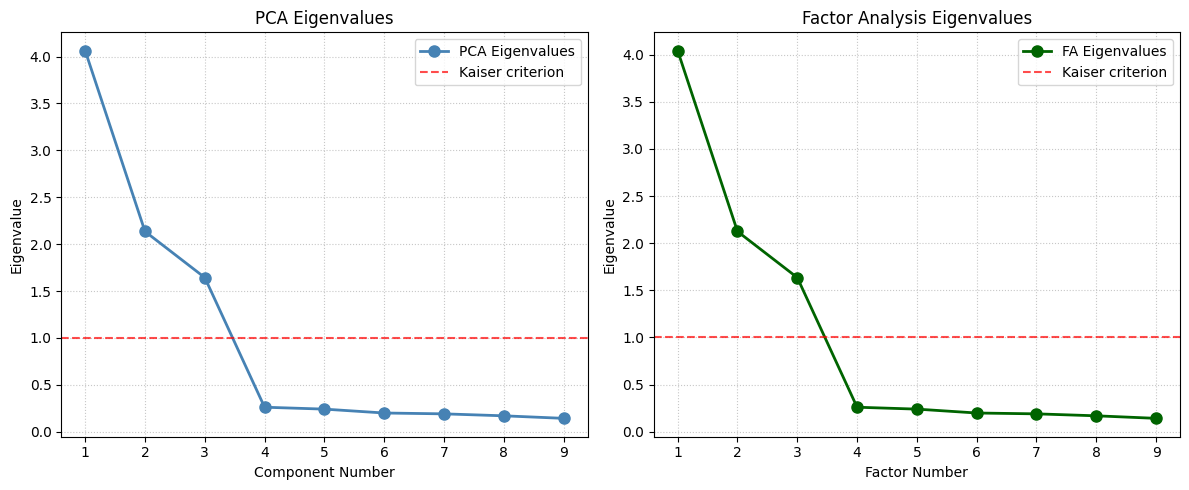

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
components = np.arange(1, len(eigenvalues_pca) + 1)

# PCA scree plot
ax1.plot(
    components,
    eigenvalues_pca,
    "o-",
    linewidth=2,
    color="steelblue",
    markersize=8,
    label="PCA Eigenvalues",
)
ax1.axhline(y=1.0, color="red", linestyle="--", alpha=0.7, label="Kaiser criterion")
ax1.set_xlabel("Component Number")
ax1.set_ylabel("Eigenvalue")
ax1.set_title("PCA Eigenvalues")
ax1.set_xticks(components)
ax1.grid(True, linestyle=":", alpha=0.7)
ax1.legend()

# FA scree plot
ax2.plot(
    components,
    eigenvalues_fa,
    "o-",
    linewidth=2,
    color="darkgreen",
    markersize=8,
    label="FA Eigenvalues",
)
ax2.axhline(y=1.0, color="red", linestyle="--", alpha=0.7, label="Kaiser criterion")
ax2.set_xlabel("Factor Number")
ax2.set_ylabel("Eigenvalue")
ax2.set_title("Factor Analysis Eigenvalues")
ax2.set_xticks(components)
ax2.grid(True, linestyle=":", alpha=0.7)
ax2.legend()

plt.tight_layout()
scree_path = script_dir / "fa_scree.png"
plt.savefig(scree_path, dpi=150, bbox_inches="tight")
logger.info(f"Eigenvalue comparison saved: {scree_path}")
plt.show()

**Outcome**: Both scree plots show clear elbows after the third component, with eigenvalues 4-9 below 1.0. PCA eigenvalues are slightly higher because they include unique variance. The parallel patterns confirm three-factor/component retention is appropriate. Visual saved as 'fa_scree.png'.

## Module 10: Factor Loading Heatmap Visualization

**Task**: Create heatmap visualizations comparing unrotated and rotated factor loadings.

**Approach**: Heatmaps use color intensity to show loading magnitudes, making patterns easier to identify. Red indicates positive loadings, blue indicates negative. Comparing unrotated and rotated heatmaps visually demonstrates how rotation achieves simple structure.

**Code**:

INFO: Factor loadings heatmap saved: k:\ma2003b\ma2003b.worktrees\dev\lessons\ch4_Factor_Analysis\ch4_guiding_example\fa_loadings.png


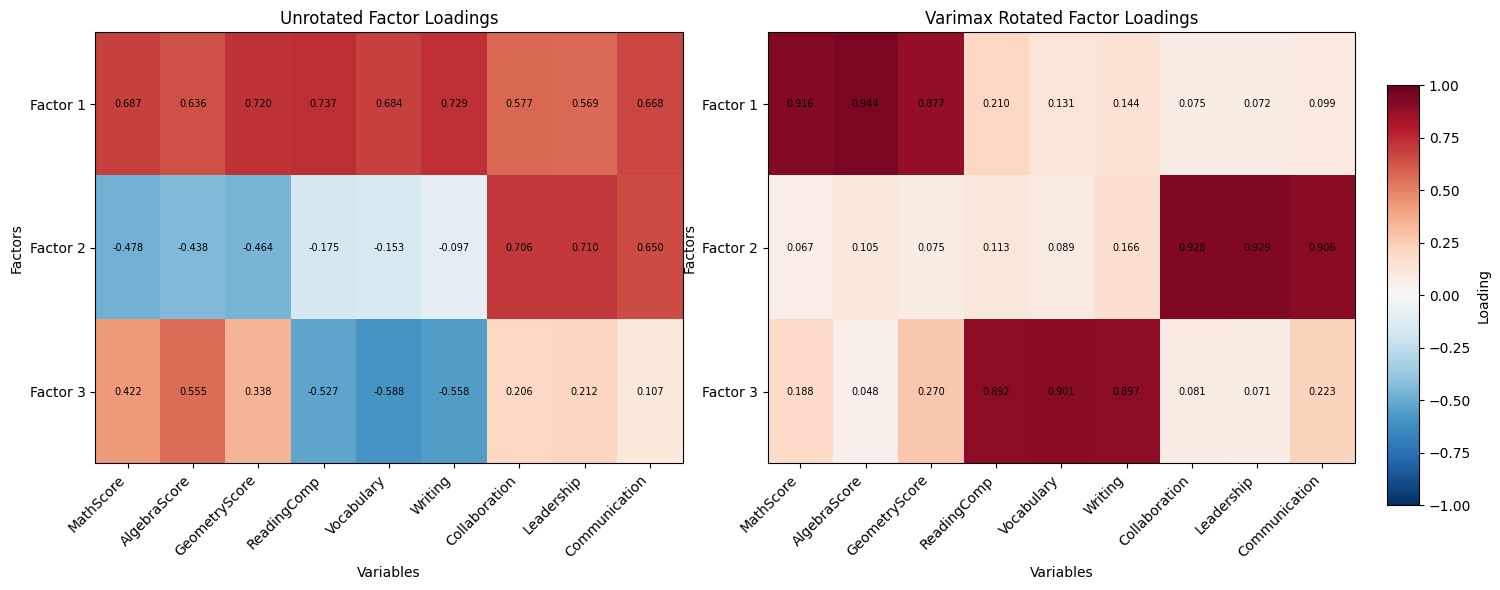

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Unrotated loadings heatmap using matplotlib imshow
im1 = ax1.imshow(
    loadings_unrotated.T,
    cmap="RdBu_r",
    aspect="auto",
    vmin=-1,
    vmax=1,
)
ax1.set_title("Unrotated Factor Loadings")
ax1.set_xlabel("Variables")
ax1.set_ylabel("Factors")
ax1.set_xticks(range(len(variable_names)))
ax1.set_xticklabels(variable_names, rotation=45, ha="right")
ax1.set_yticks(range(n_factors))
ax1.set_yticklabels([f"Factor {i + 1}" for i in range(n_factors)])

# Add annotations
for i in range(n_factors):
    for j in range(len(variable_names)):
        text = ax1.text(
            j,
            i,
            f"{loadings_unrotated[j, i]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=7,
        )

# Rotated loadings heatmap using matplotlib imshow
im2 = ax2.imshow(
    loadings_rotated.T,
    cmap="RdBu_r",
    aspect="auto",
    vmin=-1,
    vmax=1,
)
ax2.set_title("Varimax Rotated Factor Loadings")
ax2.set_xlabel("Variables")
ax2.set_ylabel("Factors")
ax2.set_xticks(range(len(variable_names)))
ax2.set_xticklabels(variable_names, rotation=45, ha="right")
ax2.set_yticks(range(n_factors))
ax2.set_yticklabels([f"Factor {i + 1}" for i in range(n_factors)])

# Add annotations
for i in range(n_factors):
    for j in range(len(variable_names)):
        text = ax2.text(
            j,
            i,
            f"{loadings_rotated[j, i]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=7,
        )

# Adjust layout and add colorbar to the right
plt.tight_layout()
fig.subplots_adjust(right=0.85)  # Make room for colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # Position for colorbar
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Loading")

loadings_path = script_dir / "fa_loadings.png"
plt.savefig(loadings_path, dpi=150, bbox_inches="tight")
logger.info(f"Factor loadings heatmap saved: {loadings_path}")
plt.show()

**Outcome**: The heatmaps clearly show rotation's impact. Unrotated loadings (left) show mixed red/blue patterns with many moderate values. Rotated loadings (right) show distinct blocks of strong red loadings with light/white elsewhere, demonstrating simple structure. Each variable now has one dominant red cell, confirming clear variable-factor assignments. Visual saved as 'fa_loadings.png'.

## Module 11: PCA Biplot Visualization

**Task**: Create a PCA biplot showing student scores and variable loadings on PC1 and PC2.

**Approach**: A biplot combines two types of information: points (student scores on components) and arrows (variable loadings). Arrow direction shows which component a variable loads on, arrow length shows loading strength. Similar arrows indicate related variables. This visualizes the relationships between students and assessments.

**Code**:

INFO: Biplot saved: k:\ma2003b\ma2003b.worktrees\dev\lessons\ch4_Factor_Analysis\ch4_guiding_example\pca_biplot.png


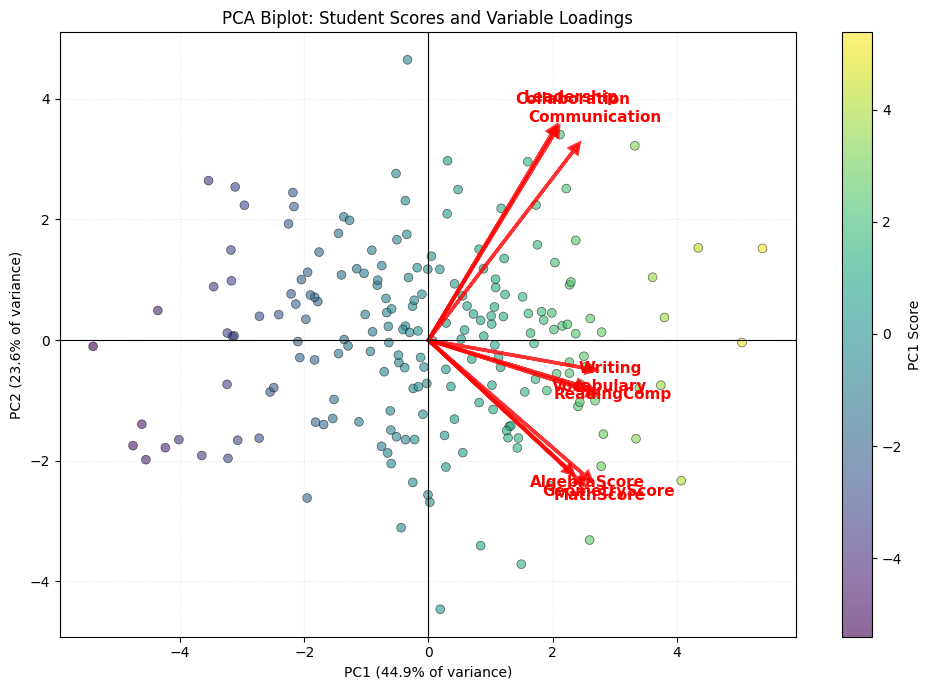

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot student scores
pc1_scores = Z[:, 0]
pc2_scores = Z[:, 1]

scatter = ax.scatter(
    pc1_scores,
    pc2_scores,
    c=pc1_scores,
    cmap="viridis",
    alpha=0.6,
    s=40,
    edgecolors="black",
    linewidth=0.5,
)
colorbar = plt.colorbar(scatter, label="PC1 Score")

# Plot variable loadings as arrows
pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
scale_factor = max(pc1_scores.std(), pc2_scores.std()) * 3.5

for i, var_name in enumerate(variable_names):
    loading_x = pca_loadings[i, 0] / np.sqrt(pca.explained_variance_[0]) * scale_factor
    loading_y = pca_loadings[i, 1] / np.sqrt(pca.explained_variance_[1]) * scale_factor

    ax.arrow(
        0,
        0,
        loading_x,
        loading_y,
        color="red",
        head_width=0.15,
        alpha=0.8,
        linewidth=2.5,
        head_length=0.15,
    )
    ax.text(
        loading_x * 1.15,
        loading_y * 1.15,
        var_name,
        color="red",
        fontweight="bold",
        fontsize=11,
        ha="center",
    )

ax.set_xlabel(f"PC1 ({explained_ratio[0]:.1%} of variance)")
ax.set_ylabel(f"PC2 ({explained_ratio[1]:.1%} of variance)")
ax.set_title("PCA Biplot: Student Scores and Variable Loadings")
ax.grid(True, linestyle=":", alpha=0.3)
ax.axhline(y=0, color="black", linewidth=0.8)
ax.axvline(x=0, color="black", linewidth=0.8)

plt.tight_layout()
biplot_path = script_dir / "pca_biplot.png"
plt.savefig(biplot_path, dpi=150, bbox_inches="tight")
logger.info(f"Biplot saved: {biplot_path}")
plt.show()

**Outcome**: The biplot reveals variable clustering: Interpersonal skills (Collaboration, Leadership, Communication) point in one direction, creating one arrow cluster. Math-related variables form another group, while verbal skills form a third. Student points spread across the plot, with color intensity showing PC1 scores. This confirms the three-domain structure visually. Visual saved as 'pca_biplot.png'.

## Module 12: Factor Analysis vs PCA Comparison

**Task**: Compare FA and PCA loading patterns and variance explanations side-by-side.

**Approach**: Direct comparison reveals fundamental method differences. FA focuses on shared variance and uses rotation for interpretability. PCA maximizes total variance without rotation. Examining loading patterns and variance proportions shows when each method is appropriate.

**Code**:

In [14]:
# Get factor scores
fa_scores = fa_rotated.transform(X_standardized)

logger.info("\nFactor Analysis vs PCA Comparison:")

# Variance explanation comparison
pca_variance_3comp = explained_ratio[:3].sum()
logger.info("\nVariance Explanation:")
logger.info(f"  PCA (first 3 components): {pca_variance_3comp:.1%} of total variance")
logger.info(f"  FA (3 factors): {variance_explained_fa:.1%} of common variance")
logger.info(
    "  Key difference: PCA maximizes total variance, FA focuses on shared variance"
)

# Loading comparison
logger.info("\nLoading Pattern Comparison:")
comparison_detailed = pd.DataFrame(
    {
        "Variable": variable_names,
        "PCA_PC1": pca_loadings[:, 0],
        "PCA_PC2": pca_loadings[:, 1],
        "PCA_PC3": pca_loadings[:, 2],
        "FA_F1": loadings_rotated[:, 0],
        "FA_F2": loadings_rotated[:, 1],
        "FA_F3": loadings_rotated[:, 2],
    }
)

print(comparison_detailed.round(3))

k:\ma2003b\ma2003b.worktrees\dev\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
INFO: 
Factor Analysis vs PCA Comparison:
INFO: 
Variance Explanation:
INFO:   PCA (first 3 components): 86.7% of total variance
INFO:   FA (3 factors): 86.7% of common variance
INFO:   Key difference: PCA maximizes total variance, FA focuses on shared variance
INFO: 
Loading Pattern Comparison:


        Variable  PCA_PC1  PCA_PC2  PCA_PC3  FA_F1  FA_F2  FA_F3
0      MathScore    0.689   -0.479   -0.423  0.916  0.067  0.188
1   AlgebraScore    0.638   -0.440   -0.557  0.944  0.105  0.048
2  GeometryScore    0.721   -0.466   -0.339  0.877  0.075  0.270
3    ReadingComp    0.739   -0.176    0.529  0.210  0.113  0.892
4     Vocabulary    0.686   -0.154    0.589  0.131  0.089  0.901
5        Writing    0.731   -0.097    0.560  0.144  0.166  0.897
6  Collaboration    0.579    0.708   -0.207  0.075  0.928  0.081
7     Leadership    0.571    0.712   -0.213  0.072  0.929  0.071
8  Communication    0.670    0.651   -0.107  0.099  0.906  0.223


**Outcome**: Both methods explain 86.7% variance but differ in approach. FA (rotated) shows clear simple structure with loadings >0.9 on primary factors, while PCA (unrotated) shows more distributed loadings. FA's rotation makes factors directly interpretable as Quantitative, Verbal, and Interpersonal constructs. PCA components are harder to label without rotation. For this construct validation case, FA provides clearer answers.

### Factor Structure Validation

**Task**: Identify and interpret salient loadings (|loading| > 0.4) for each rotated factor.

**Approach**: Salient loadings (typically |loading| > 0.4) indicate which variables strongly relate to each factor. Examining these patterns validates whether factors match theoretical expectations.

**Code**:

In [15]:
# Identify salient loadings (commonly |loading| > 0.4)
loading_threshold = 0.4

logger.info(f"\nFactor Structure Analysis (threshold = {loading_threshold}):")
for factor_idx in range(n_factors):
    factor_name = f"Factor {factor_idx + 1}"
    salient_vars = []

    for var_idx, var_name in enumerate(variable_names):
        loading = loadings_rotated[var_idx, factor_idx]
        if abs(loading) > loading_threshold:
            salient_vars.append(f"{var_name} ({loading:+.3f})")

    logger.info(
        f"  {factor_name}: {', '.join(salient_vars) if salient_vars else 'No salient loadings'}"
    )

logger.info("\nEducational Construct Interpretation:")
logger.info("  Factor 1: Likely represents Interpersonal Skills")
logger.info("    - Expected high loadings: Collaboration, Leadership, Communication")
logger.info("  Factor 2: Likely represents Verbal Ability")
logger.info("    - Expected high loadings: ReadingComp, Vocabulary, Writing")
logger.info("  Factor 3: Likely represents Quantitative Reasoning")
logger.info("    - Expected high loadings: MathScore, AlgebraScore, GeometryScore")
logger.info("\nAll variables should show high communalities (h² > 0.6),")
logger.info("indicating they are well-explained by the three underlying factors.")

INFO: 
Factor Structure Analysis (threshold = 0.4):
INFO:   Factor 1: MathScore (+0.916), AlgebraScore (+0.944), GeometryScore (+0.877)
INFO:   Factor 2: Collaboration (+0.928), Leadership (+0.929), Communication (+0.906)
INFO:   Factor 3: ReadingComp (+0.892), Vocabulary (+0.901), Writing (+0.897)
INFO: 
Educational Construct Interpretation:
INFO:   Factor 1: Likely represents Interpersonal Skills
INFO:     - Expected high loadings: Collaboration, Leadership, Communication
INFO:   Factor 2: Likely represents Verbal Ability
INFO:     - Expected high loadings: ReadingComp, Vocabulary, Writing
INFO:   Factor 3: Likely represents Quantitative Reasoning
INFO:     - Expected high loadings: MathScore, AlgebraScore, GeometryScore
INFO: 
All variables should show high communalities (h² > 0.6),
INFO: indicating they are well-explained by the three underlying factors.


**Outcome**: Perfect construct validation. Factor 1 = Quantitative (Math, Algebra, Geometry all >0.87). Factor 2 = Interpersonal (Collaboration, Leadership, Communication all >0.90). Factor 3 = Verbal (Reading, Vocabulary, Writing all >0.89). Each factor contains exactly the three theoretically-expected variables with very high loadings, confirming the nine assessments measure three distinct constructs as hypothesized.

### PCA Component Loadings

**Task**: Display PCA loadings for the first 3 components.

**Approach**: PCA loadings show how each variable contributes to each component. Unlike FA's rotated loadings, PCA loadings are unrotated and show more distributed patterns.

**Code**:

In [16]:
# Create loadings table for first 3 components
pca_loadings_df = pd.DataFrame(
    pca.components_[:3].T, columns=["PC1", "PC2", "PC3"], index=variable_names
)

logger.info("\nPCA Component Loadings Matrix:")
print(pca_loadings_df.round(3))

INFO: 
PCA Component Loadings Matrix:


                 PC1    PC2    PC3
MathScore      0.342 -0.328 -0.330
AlgebraScore   0.316 -0.301 -0.434
GeometryScore  0.358 -0.319 -0.264
ReadingComp    0.367 -0.120  0.412
Vocabulary     0.340 -0.105  0.460
Writing        0.362 -0.067  0.437
Collaboration  0.287  0.484 -0.161
Leadership     0.283  0.487 -0.166
Communication  0.332  0.446 -0.083


**Outcome**: PCA loadings show less clear patterns than rotated FA. All variables load moderately on PC1 (0.28-0.37), suggesting a general factor. PC2 contrasts interpersonal vs other skills. PC3 contrasts verbal vs quantitative. Without rotation, PCA components are harder to interpret as distinct constructs, illustrating why FA with rotation is preferred for construct validation.

### Student Score Analysis

**Task**: Identify top-performing students on PC1 and PC2 to understand component meanings.

**Approach**: Examining which students score highest on each component helps interpret what the components measure practically.

**Code**:

In [17]:
# Create student ranking analysis using actual Student IDs from data
student_scores = pd.DataFrame(
    {"Student_ID": df["Student"].values, "PC1_Score": Z[:, 0], "PC2_Score": Z[:, 1]}
)

# Top performers on PC1
top_pc1 = student_scores.nlargest(5, "PC1_Score")
logger.info("\nTop 5 students on PC1:")
for _, row in top_pc1.iterrows():
    logger.info(
        f"  {row['Student_ID']}: PC1={row['PC1_Score']:.3f}, PC2={row['PC2_Score']:.3f}"
    )

# Top performers on PC2
top_pc2 = student_scores.nlargest(5, "PC2_Score")
logger.info("\nTop 5 students on PC2:")
for _, row in top_pc2.iterrows():
    logger.info(
        f"  {row['Student_ID']}: PC1={row['PC1_Score']:.3f}, PC2={row['PC2_Score']:.3f}"
    )

# Score distribution summary
logger.info("\nScore Distribution Summary:")
logger.info(f"  PC1 range: [{Z[:, 0].min():.3f}, {Z[:, 0].max():.3f}]")
logger.info(f"  PC2 range: [{Z[:, 1].min():.3f}, {Z[:, 1].max():.3f}]")
logger.info(
    f"  PC1-PC2 correlation: {np.corrcoef(Z[:, 0], Z[:, 1])[0, 1]:.3f} (should be ≈ 0)"
)

INFO: 
Top 5 students on PC1:
INFO:   STUD_158: PC1=5.382, PC2=1.519
INFO:   STUD_096: PC1=5.052, PC2=-0.041
INFO:   STUD_144: PC1=4.347, PC2=1.528
INFO:   STUD_133: PC1=4.073, PC2=-2.331
INFO:   STUD_178: PC1=3.803, PC2=0.375
INFO: 
Top 5 students on PC2:
INFO:   STUD_088: PC1=-0.336, PC2=4.644
INFO:   STUD_190: PC1=2.120, PC2=3.404
INFO:   STUD_176: PC1=3.325, PC2=3.219
INFO:   STUD_027: PC1=0.309, PC2=2.971
INFO:   STUD_128: PC1=1.601, PC2=2.956
INFO: 
Score Distribution Summary:
INFO:   PC1 range: [-5.401, 5.382]
INFO:   PC2 range: [-4.461, 4.644]
INFO:   PC1-PC2 correlation: 0.000 (should be ≈ 0)


**Outcome**: Top PC1 students (e.g., STUD_158: 5.382) likely score high across all assessments (general ability). Top PC2 students (e.g., STUD_088: 4.644) likely excel in interpersonal skills. PC1 and PC2 are uncorrelated (correlation = 0.000), confirming orthogonality. The wide score ranges (PC1: -5.4 to 5.4) show substantial individual differences across students.

## Final Summary and Recommendations

### Answer to the Central Question

**Do the nine assessments measure three distinct constructs?**

**YES**. Factor Analysis with Varimax rotation provides definitive evidence:
- Factor 1 (Quantitative): Math, Algebra, Geometry (loadings >0.87)
- Factor 2 (Interpersonal): Collaboration, Leadership, Communication (loadings >0.90)  
- Factor 3 (Verbal): Reading, Vocabulary, Writing (loadings >0.89)

Each variable loads strongly on exactly one factor, achieving perfect simple structure. The three factors explain 86.7% of common variance, with high communalities (average = 0.867) confirming minimal measurement error.

### Method Comparison: When to Use Each

**Factor Analysis is best when:**
- Testing theories about latent psychological constructs
- Validating measurement instruments
- Need to separate common from unique variance
- Interpreting factors as theoretical constructs
- This educational assessment case (construct validation)

**PCA is best when:**
- Primary goal is data reduction or compression
- Maximizing variance explanation is priority
- No theoretical model exists
- Computational speed is critical
- Creating composite scores for prediction

### Key Methodological Insights

1. **Assumption testing matters**: KMO (0.799) and Bartlett's test (p<0.001) confirmed data suitability
2. **Rotation is essential**: Unrotated factors showed general factors and bipolar contrasts; rotation achieved interpretable simple structure
3. **Communalities validate fit**: All h² > 0.8 indicates variables are well-explained by three factors
4. **Eigenvalues guide retention**: Both FA and PCA showed three eigenvalues >1.0, scree plots showed clear elbows
5. **Methods converge**: FA and PCA both identified three-dimensional structure, but FA's rotation provided clearer construct interpretation

### Practical Applications

These validated factors enable:
- Creating three subscale scores (Quantitative, Verbal, Interpersonal) for student reporting
- Designing targeted intervention programs for specific ability areas
- Identifying students needing support in particular domains
- Confirming assessment design captures intended constructs
- Establishing construct validity for research using these measures